In [1]:
# Здесь загружаются названия референса, файла с ридами (bam), файла с геномами
# import argparse

# parser = argparse.ArgumentParser(description='Supply reference fasta and bam file')
# parser.add_argument('ref',
#                     help='reference fasta')
# parser.add_argument('bam',
#                     help='bam file')


# args = parser.parse_args()
# ref_fname = args.ref
# bam_fname = args.bam

In [2]:
# Тестовые файлы для проверки
ref_fname     = 'refchrm.fa'
bam_fname     = 'test9.bam'
genomes_fname = 'contaminants.fa'

In [3]:
# Импорт всех необходимых библиотек
import os
from collections import Counter
import pysam
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
from scipy.special import binom
import scipy.stats as st
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from multiprocess import Pool
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext cython

In [4]:
#Cython part

In [5]:
%%cython -a --compile-args=-O3

from tqdm import tqdm
import pysam
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import Counter
from IPython.display import clear_output
cimport cython
import numpy as np
from cython.parallel import prange
from libc.math cimport pow
from scipy.special import binom

# Считывает число картированных ридов
# returns number of mapped reads
def get_num_reads(str bam_fname):
    ''''
    This function calculate mapped reads
    
    '''
    samfile = pysam.AlignmentFile(bam_fname, "rb")
    num_reads = 0
    for read in samfile.fetch('chrM'):
        if read.is_mapped:
            num_reads += 1
    samfile.close()
    return num_reads

def bam2consensus(bam_fname, double ac_threshold=0, double af_threshold=0):
    '''
    NOW UNUSED
    Make consensus fasta
    
    Parameters:
        ref_name : str
        path to a file with reference
        bam_fname : str
        path to a bam file
        ac_threshold : float
        af_threshold : float
        
    '''
    cdef str consensus = ''
    cdef int max_count, total_count
    cdef str allele
    cdef str max_allele
   
        # consensus = "N" * len(record)

    with pysam.AlignmentFile(bam_fname, "rb") as bam:
        allele_counter = Counter()
        for pileup_column in tqdm(bam.pileup(), total=16569, desc = 'consensus dna'):
            assert pileup_column.reference_name == 'chrM'
            pos = pileup_column.reference_pos

            allele_counter.clear()
            for pileup_read in pileup_column.pileups:
                if pileup_read.is_del:
                    allele = "-"
                else:
                    allele = pileup_read.alignment.query_sequence[
                        pileup_read.query_position]
                allele_counter[allele] += 1

            max_allele = "N"
            max_count, total_count = 0, 0
            for allele, count in allele_counter.items():
                if count > max_count:
                    max_count = count
                    max_allele = allele
                total_count += count

            assert max_allele in "ACGTN-"
            if (max_count >= ac_threshold and
                max_count / total_count >= af_threshold):
                consensus += max_allele
            else:
                consensus += 'N'

    return consensus.replace('-', '')

#Produces matrices M and N described in article
@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(True)
def get_MN(char[:, :] genomes,str bam_fname, long[:] aln_coords, same, trunc = 0, verbosity = False):
    '''
    Make matrices and base error for the method.
    
    Parameters:
        genomes: char
        vector where on j row is j genome.
        
        bam_fname: str
        bam file
        
        same : dict
        dictionary of positions and bases where all genomes have the same base.
    
    Output:
        M : np.ndarray[float, float]
            matrix where M[i, j] is number of bases where read i has same bases with genome 
        N : np.ndarray[float, float]
            matrix where N[i, j] is number of bases where read i has different bases with genome j

    
    '''
    bam = pysam.AlignmentFile(bam_fname, "rb")
    cdef double[:, :] M, N
    cdef int k, i, j, pos, offset
    offset = 0
    cdef double correct, incorrect, P_cor
    cdef str seq
    cdef long num_reads = get_num_reads(bam_fname)
    cdef int num_genomes = genomes.shape[0]
    cdef double base_incorr = 0
    cdef double base_total = 0
    N = np.zeros((num_reads, num_genomes))
    M = np.zeros((num_reads, num_genomes))
    i = 0
    j = 0
    for read in tqdm(bam.fetch('chrM'), total = bam.count(), desc = 'MN tables'):
        
        if not read.is_mapped:
            continue
            
        seq = read.query_sequence
        pos = read.reference_start
        
        if read.cigartuples[0][0] == 4: #read is soft clipped
            left_trim = read.cigartuples[0][1]
            seq = seq[left_trim:]
            
        # if read.cigartuples[-1][0] == 4: #read is soft clipped
        #     right_trim = read.cigartuples[-1][1]
        #     seq = seq[:-right_trim]
        # IDK should i use it because in my data there is no softclip to the right
        
        oldest_pos = pos
        
        qual = read.query_qualities
        
        ins_pos = 0
        
        for j in range(num_genomes):
            if "I" in read.cigarstring: # Check for indels
                if j == 0:
                    # print('INDEL')
                    M[i, j] = -1
                    N[i, j] = -1
                else:
                    cigar = read.cigartuples

                    for m in range(len(cigar)):
                        if cigar[m][0] == 1:
                            for s in range(m):
                                ins_pos += cigar[s][1]
                            break
                            
                    # if pos + ins_pos < genomes.shape[1] and chr(genomes[s, aln_coords[pos] + ins_pos]) != seq[aln_coords[pos]+ins_pos]:
                    #     M[i, j] = -1
                    #     N[i, j] = -1
            
            
            
            if "D" in read.cigarstring: # Check for indels
                if j == 0:
                    M[i, j] = -1
                    N[i, j] = -1
                else: # пока нуждается в доработке но посмотрим
                    cigar = read.cigartuples
                    ins_pos = 0
                    for m in range(len(cigar)):
                        if cigar[m][0] == 1:
                            for s in range(m):
                                ins_pos += cigar[s][1]
                            # break
                    if chr(genomes[s, aln_coords[pos+ins_pos]]) != '-':
                        M[i, j] = -1
                        N[i, j] = -1
                        

                        
            correct = 0
            incorrect = 0
            offset = 0
            debug_str = ''

            for k in range(trunc,len(seq)-trunc):
                
                if k + pos + offset >= genomes.shape[1]:
                    break
                # if k + pos + offset >= len(aln_coords):
                    # break;
                    
                while chr(genomes[j, aln_coords[pos] + k +offset]).upper() == '-' or chr(genomes[0, aln_coords[pos] + k + offset]).upper() == '-':
                    if chr(genomes[j, aln_coords[pos] + k + offset]).upper() == '-' and chr(genomes[0, aln_coords[pos] + k + offset]).upper() == '-':
                        offset += 1
                    
                    elif chr(genomes[j, aln_coords[pos] + k + offset]).upper() == '-':
                        if 'D' not in read.cigarstring:
                            M[i, j] = -1
                            N[i, j] = -1
                            break
                        else:
                            correct += 1
                            offset += 1 
                        
                    elif chr(genomes[0, aln_coords[pos] + k + offset]).upper() == '-':
                        if 'I' not in read.cigarstring:
                            M[i, j] = -1
                            N[i, j] = -1
                            break
                        else:
                            break
                    if k + pos + offset >= genomes.shape[1]:
                        break
                            
                    # print(pos + k + offset)
                
                if chr(genomes[j, aln_coords[pos] + k + offset]).upper() == 'N' or seq[k] == 'N':
                    # correct += 0.25
                    # incorrect += 0.75
                    # correct +=1
                    #TODO: DECIDE WHETHER WE SHOULD UASE IT
                    pass
                                
                elif seq[k] == chr(genomes[j, aln_coords[pos] + k + offset]).upper(): #means that read has same base with j genome
                    P_cor = 1 - 10**(- qual[k]/10)
                    correct += P_cor
                    incorrect += 1 - P_cor
                    if verbosity:
                        debug_str += f'{seq[k]}, {chr(genomes[j][aln_coords[pos] + k + offset ]).upper()} => +1\n'
                    # correct += 1 #old version for debugging
                    if aln_coords[pos] + k +offset in same:
                        base_total += 1
                        
                else:
                    # print(seq[k], chr(genomes[j][k+pos]).upper()) #means that read has same difference with j genome
                    P_cor = (10**(- qual[k]/10))/3
                    incorrect += 1 - P_cor
                    correct += P_cor
                    if verbosity:
                        debug_str += f'{seq[k]}, {chr(genomes[j][aln_coords[pos] + k + offset]).upper()} => -1\n'
                    # incorrect += 1
                    if aln_coords[pos] + k + offset in same:
                        # print("plus incorrect")
                        base_total += 1
                        base_incorr += 1
                        

            if M[i, j] != -1:
                M[i, j] = correct
                N[i, j] = incorrect

                
                
            # print("total:", M[i,j],N[i,j], sep='\n')
            if verbosity:
                if M[i, j] < N[i, j] and pos != 0:
                    print('ERROR',i, j, seq, oldest_pos, pos, debug_str, M[i, j], N[i, j], sep = '\n')
                
        
        i += 1
        
    bam.close()
    cdef double base_err = base_incorr / base_total
    return np.array(M, dtype=np.float64), np.array(N, dtype=np.float64), base_err

@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def get_mc(double[:, ::1] m, double[:, ::1] n, double eps):
    ''''
    Преобразует M N и base_err в матрицу mc,  которая в дальнейшем используется для остальных вычислений
    '''
    cdef double[:,::1] mc
    cdef long num_reads = m.shape[0]
    cdef long num_genomes = m.shape[1] 
    cdef long j
    mc = np.zeros((num_reads, num_genomes))
    for i in range(num_reads):
        for j in range(num_genomes):
            if m[i, j] == -1:
                mc[i, j] = 0
            else:
                mc[i, j] = binom(m[i, j] + n[i, j], m[i, j]) * (1 - eps)**(m[i, j]) * eps**n[i, j]
    return np.asarray(mc)
    




@cython.cdivision(True)
# @cython.wraparound(False)
# @cython.boundscheck(False)
def get_Zi(double[:,::1] mc, double[::1] p,double eps, long i):
    cdef long num_reads = mc.shape[0]
    cdef long num_genomes = mc.shape[1] 
    cdef long j
    cdef long Z
    cdef double[:] probs
    cdef double s
    s = 0
    probs = np.zeros(num_genomes, dtype = float)
    

    for j in range(num_genomes):
        probs[j] = mc[i, j] * p[j]
        s += probs[j]

        
    for j in range(num_genomes):
        probs[j] =probs[j] / s
        
    Z = random_choice(probs)

    return Z

@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def get_eta(long[:] z,int num_genomes):
    '''
    create vector eta
    eta[j] is number of reads that were predicted to be from j-th genome 
    '''
    
    cdef long[:] eta
    eta = np.zeros(num_genomes, dtype = int)
    
    cdef int num_reads
    num_reads = z.shape[0]
    
    cdef int i
    
    for i in range(num_reads):
        eta[z[i]] += 1
        
    return np.array(eta)


cdef extern from "stdlib.h":
    double drand48()
    void srand48(long int seedval)

    
@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def random_choice(double[:] probs):
    '''Returns random number from 0 to n-1 according to probs
        Check if probs do not sum up to 1!'''
    
    cdef double s = 0
    cdef int i
    cdef int l = len(probs)
    
    

    
    cdef double x = drand48()
    cdef double cum_probs = 0
    cdef long n = 0
    while x > cum_probs:
        cum_probs += probs[n]
        n += 1
    n -= 1
    return n





@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(True)
def get_glM(char[:, :] genomes,str bam_fname, long[:] aln_coords, same, trunc = 0, verbosity = False):
    '''
    Make matrices and base error for the method.
    
    Parameters:
        genomes: char
        vector where on j row is j genome.
        
        bam_fname: str
        bam file
        
        same : dict
        dictionary of positions and bases where all genomes have the same base.
    
    Output:
        M : np.ndarray[float, float]
            matrix where M[i, j] is number of bases where read i has same bases with genome 
        N : np.ndarray[float, float]
            matrix where N[i, j] is number of bases where read i has different bases with genome j

    
    '''
    bam = pysam.AlignmentFile(bam_fname, "rb")
    cdef double[:, :] MC
    cdef int k, i, j, pos, offset
    offset = 0
    cdef double correct, incorrect, P_cor
    cdef str seq
    cdef long num_reads = get_num_reads(bam_fname)
    cdef int num_genomes = genomes.shape[0]
    cdef double base_incorr = 0
    cdef double base_total = 0
    MC = np.full((num_reads, num_genomes), 1, dtype = float)
    i = 0
    j = 0
    for read in tqdm(bam.fetch('chrM'), total = bam.count(), desc = 'MN tables'):
        
        if not read.is_mapped:
            continue
            
        seq = read.query_sequence
        pos = read.reference_start
        
        if read.cigartuples[0][0] == 4: #read is soft clipped
            left_trim = read.cigartuples[0][1]
            seq = seq[left_trim:]
            
        # if read.cigartuples[-1][0] == 4: #read is soft clipped
        #     right_trim = read.cigartuples[-1][1]
        #     seq = seq[:-right_trim]
        
        
        oldest_pos = pos
        
        qual = read.query_qualities
        
        ins_pos = 0
        
        for j in range(num_genomes):
            if "I" in read.cigarstring: # Check for indels
                if j == 0:
                    # print('INDEL')
                    MC[i, j] = 0
                else:
                    cigar = read.cigartuples

                    for m in range(len(cigar)):
                        if cigar[m][0] == 1:
                            for s in range(m):
                                ins_pos += cigar[s][1]
                            break
                            
                    # if pos + ins_pos < genomes.shape[1] and chr(genomes[s, aln_coords[pos] + ins_pos]) != seq[aln_coords[pos]+ins_pos]:
                    #     M[i, j] = -1
                    #     N[i, j] = -1
            
            
            
            if "D" in read.cigarstring: # Check for indels
                if j == 0:
                    MC[i, j] = 0
                else: # пока нуждается в доработке но посмотрим
                    cigar = read.cigartuples
                    ins_pos = 0
                    for m in range(len(cigar)):
                        if cigar[m][0] == 1:
                            for s in range(m):
                                ins_pos += cigar[s][1]
                            # break
                    if chr(genomes[s, aln_coords[pos+ins_pos]]) != '-':
                        MC[i, j] = 0

                        

                        
            offset = 0
            debug_str = ''

            for k in range(trunc,len(seq)-trunc):
                
                if k + pos + offset >= genomes.shape[1]:
                    break
                # if k + pos + offset >= len(aln_coords):
                    # break;
                    
                while chr(genomes[j, aln_coords[pos] + k +offset]).upper() == '-' or chr(genomes[0, aln_coords[pos] + k + offset]).upper() == '-':
                    if chr(genomes[j, aln_coords[pos] + k + offset]).upper() == '-' and chr(genomes[0, aln_coords[pos] + k + offset]).upper() == '-':
                        offset += 1
                    
                    elif chr(genomes[j, aln_coords[pos] + k + offset]).upper() == '-':
                        if 'D' not in read.cigarstring:
                            MC[i, j] = 0
                            break
                        else:
                            offset += 1 
                        
                    elif chr(genomes[0, aln_coords[pos] + k + offset]).upper() == '-':
                        if 'I' not in read.cigarstring:
                            MC[i, j] = 0
                            break
                        else:
                            break
                    if k + pos + offset >= genomes.shape[1]:
                        break
                            
                    # print(pos + k + offset)
                
                if chr(genomes[j, aln_coords[pos] + k + offset]).upper() == 'N' or seq[k] == 'N':
                    # correct += 0.25
                    # incorrect += 0.75
                    # correct +=1
                    pass
                                
                elif seq[k] == chr(genomes[j, aln_coords[pos] + k + offset]).upper(): #means that read has same base with j genome
                    P_cor = 1 - 10**(- qual[k]/10)
                    MC[i, j] *= P_cor
                    if verbosity:
                        debug_str += f'{seq[k]}, {chr(genomes[j][aln_coords[pos] + k + offset ]).upper()} => +1\n'
                    # correct += 1 #old version for debugging
                        
                else:
                    # print(seq[k], chr(genomes[j][k+pos]).upper()) #means that read has same difference with j genome
                    P_cor = (10**(- qual[k]/10))/3
                    # incorrect += 1 - P_cor
                    MC[i, j] *= P_cor
                    if verbosity:
                        debug_str += f'{seq[k]}, {chr(genomes[j][aln_coords[pos] + k + offset]).upper()} => -1\n'
                    # incorrect += 1

                        

           

                
                
         
                
        
        i += 1
        
    bam.close()
    return np.array(MC, dtype=np.float64)


In [6]:
def get_base_err(bam_fname, ref, aln_pos, same_set):
    bam = pysam.AlignmentFile(bam_fname, "rb")
    correct = 0
    incorrect = 0
    for readId, read in enumerate(bam.fetch('chrM')):
        
        if not read.is_mapped or 'D' in read.cigarstring or 'I' in read.cigarstring:
            continue
            
        seq = read.query_sequence
        pos = read.reference_start
        
        if read.cigartuples[0][0] == 4: #read is soft clipped
            left_trim = read.cigartuples[0][1]
            seq = seq[left_trim:]
                        

                        
        
        offset = 0
        debug_str = ''

        for k in range(len(seq)):
            if aln_pos[pos+k] in same_set:
                if seq[k].upper() == ref[aln_pos[pos+k]]:
                    correct+=1
                else:
                    # print(pos, k, readId)
                    incorrect += 1
    return correct, incorrect, incorrect/(correct + incorrect)
                
    

In [7]:
# def consensus_caller(ref_fname, bam_fname):
#     base = bam_fname[:-4]
#     os.system(f"samtools view {bam_fname} chrM -o {base+'_mt.bam'}")
#     base = base + '_mt'
#     os.system(f'samtools consensus -o {base}_st.fa {bam_fname}') #st means samtools
#     os.system(f'bwa index -a bwtsw {base}_st.fa') #indexing consensus
#     os.system(f'samtools faidx {base}_st.fa')
#     os.system(f'rm {base}.dict')
#     os.system(f'picard CreateSequenceDictionary R={base}.fa O={base}.dict')
#     os.system(f'samtools fastq {bam_fname} > {base}.fq')
#     os.system(f'bwa aln -l 1000 -t 10 {base}_st.fa {base}.fq > {base}_ra.sai')
#     os.system(f"bwa samse -r '@RG\\tID:{base}\\tLB:{base}_L1\\tPL:ILLUMINA\\tSM:{base}' {base}_st.fa {base}_ra.sai {base}.fq |  samtools sort -O BAM -o {base}_ra.sort.bam")
#     os.system(f'samtools index {base}_ra.sort.bam')
#     consensus = bam2consensus(f'{base}_st.fa', f'{base}_ra.sort.bam')
#     consensus_fa = '>chrM\n'+''.join(consensus) +'\n'
#     with open(f'{base}.fa', 'w') as new_genomes:
#         new_genomes.write(consensus_fa)
#     return consensus
    
    

In [8]:
def preprocess(ref_fname, genomes_fname, bam_fname):
    
    base = bam_fname[:-4]
    
    pysam.index(bam_fname);
    
    os.system(f"samtools view {bam_fname} chrM -o {base+'_mt.bam'}")
    base = base + '_mt'
    
    print('#EXTRACTING MTDNA OK')
    
    # Один из вариантов получения консенсуса, работает не очень хорошо.
    '''consensus = bam2consensus(ref_fname, bam_fname)
    consensus_fa = '>chrM\n'+''.join(consensus) +'\n'
    with open(f'{base}.fa', 'w') as new_genomes:
        new_genomes.write(consensus_fa)'''
    
    
    # os.system(f'samtools consensus -o {base}.fa {bam_fname}')
    
#     os.system(f'sh gatkconsensus.sh {ref_fname} {base}.bam  {base}1.fa')
#     os.system(f'''awk -i '/^>/{{print ">chrM"; next}}{{print}}' {base}1.fa > {base}.fa''')
#     os.system(f'rm {base}1.fa')
    
    # os.system(f'cp genome_0.fa {base}.fa')
    
    os.system(f'bcftools mpileup  -d 2000 -m 3 -C50 -q 30 -EQ 20 -f {ref_fname} {base}.bam | bcftools call -m --ploidy 1 > {base}.vcf')
    os.system(f'perl CnsMaj3_1.pl -i {base}.vcf -o {base}.fa -l 16569 -cov 1 -diff 0.5 -idiff 0.5 -h {base} -callindels no > {base}.cns')
    
    # return 0
    
    print('#CONSENSUS IS READY')
    
    os.system(f'cat {base}.fa {genomes_fname} > {base}_genomes.fa'); # gather consensus and possible contaminants together
    os.system(f'mafft {base}_genomes.fa >  {base}_aligned.fa') # do multiple alignment
    aligned_genomes = f'{base}_aligned.fa'
    print("#ALL GENOMES ARE READY")
    # new_cons = list(SeqIO.parse(f'{base}_aligned.fa', "fasta"))[0]
    # SeqIO.write(new_cons, f'{base}.real.fa', "fasta") #gives you reference after it have been realigned with MAFFT
    os.system(f'bwa index -a bwtsw {base}.fa') #indexing consensus
    os.system(f'samtools faidx {base}.fa')
    os.system(f'rm {base}.dict')
    os.system(f'picard CreateSequenceDictionary R={base}.fa O={base}.dict')
    os.system(f'samtools fastq {bam_fname} > {base}.fq')
    os.system(f'bwa aln -l 1000 -t 10 {base}.fa {base}.fq > {base}_ra.sai')
    os.system(f"bwa samse -r '@RG\\tID:{base}\\tLB:{base}_L1\\tPL:ILLUMINA\\tSM:{base}' {base}.fa {base}_ra.sai {base}.fq | samtools sort -O BAM -o {base}_ra.sort.bam")
    # os.system(f'picard MarkDuplicates I={base}_ra.sort.bam O={base}_ra.sort.rmdup.bam METRICS_FILE=metrics.txt TMP_DIR=temp REMOVE_DUPLICATES=true ASSUME_SORTED=true ') #VALIDATION_STRINGENCY=LENIENT
    
    total_reads = int(pysam.view('-c', bam_fname))
    need_reads = 64000
    proportion = need_reads / total_reads
    # print(proportion)

    # -s {123+proportion}
    os.system(f'samtools view  -O BAM {base}_ra.sort.bam | samtools sort > {base}_ra.sort.rmdup.bam')
    
    pysam.index(f'{base}_ra.sort.rmdup.bam');
    os.system(f'samtools calmd -Erb {base}_ra.sort.rmdup.bam {base}.fa > {base}_ra.final.bam 2>/dev/null');
    bam_final = f'{base}_ra.final.bam'
    os.system(f'samtools index {base}_ra.final.bam')
    os.system(f'rm {base}_ra.sai')
    print("#BAM FILE IS READY")
    return bam_final, aligned_genomes

In [9]:
def make_genomes_arr(genomes_fname):
    genomes = list()
    for record in SeqIO.parse(genomes_fname, "fasta"):
        genomes.append(str(record.seq))
    genomes_arr = np.array([list(x) for x in genomes], dtype = 'S1')
    return genomes_arr

In [10]:
def get_same(genomes_arr):
    same_positions = []
    for i in range(genomes_arr.shape[1]):
        if len(np.unique(genomes_arr[:,i])) == 1:
            same_positions.append(i)
    return set(same_positions)

In [11]:
def get_base_err(bam_fname, same_dict):
    samfile = pysam.AlignmentFile(bam_fname, "rb" )
    same_positions = list(same_dict.keys())
    correct = 0
    total = 0
    samfile = pysam.AlignmentFile(bam_fname, "rb" )
    for pileupcolumn in tqdm(samfile.pileup("chrM")):
        pos = pileupcolumn.pos
        if pos not in same_positions:
            continue

        for pileupread in pileupcolumn.pileups:
            if not pileupread.is_del and not pileupread.is_refskip:
                total += 1
                # query position is None if is_del or is_refskip is set.
                nbase =  pileupread.alignment.query_sequence[pileupread.query_position]
                if nbase == same[pos].decode('ascii').upper():
                    correct += 1
    base_err = 1 - correct/total
    samfile.close()
    return base_err

In [12]:
def get_aln_pos(reference):
    aln_coor = []
    for i in range(len(reference)):
        if reference[i] != '-':
            aln_coor.append(i)
            
    return np.asarray(aln_coor)

In [13]:
def do_mcmc(n_iterations = 50000, output_file='', n_threads=8, model=0, show_each=10):
    if output_file != '':
        res = open(output_file,'w')
    p_list = []
    num_reads, num_genomes  = MC.shape
    print(MC.shape)
    p = np.random.dirichlet([1]*num_genomes)
    # pool = Pool(n_threads)
    for i in tqdm(range(n_iterations) ):
        
        func = lambda x: get_Zi(MC, p, base_err, x)
        
        # Z = np.array(pool.map_async(func, range(num_reads)).get())
        Z = np.array([func(s) for s in range(num_reads) ])
        eta = get_eta(Z, num_genomes)
        if model == 0:
            p0 = np.random.beta(1 + eta[0],1+num_reads-eta[0])
            p_other = np.random.dirichlet(1+ eta[1:])
            p_other *= (1-p0)/p_other.sum()

            p[0] = p0
            p[1:] = p_other
            p_list.append(p[0])
        else:
            p = np.random.dirichlet(1+ eta)
            p_list.append(p[0])
        if output_file != '':
            res.write(f'iteration {i}')
            res.write(str(p[0]))
        if i % show_each == 0:
            # print(p[0], p[1:].sum()) 
            print(p)
    # pool.close()
    if output_file != '':
        res.close()
    return p_list

In [14]:
bam, genomes = preprocess(ref_fname, genomes_fname, bam_fname)

#EXTRACTING MTDNA OK
#CONSENSUS IS READY


[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 2000
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8176 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 2466 ambiguous characters.
    1 / 3
done.

Constructing a UPGMA tree (efffree=0) ... 
    0 / 3
done.

Progressive alignment 1/2... 
STEP     2 / 2 
done.

Making a distance matrix from msa.. 
    0 / 3
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 3
done.

Progressive alignment 2/2... 
STEP     2 / 2 
done.

disttbfast (nuc) Version 7.490
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The defa

#ALL GENOMES ARE READY


INFO	2022-11-14 03:20:03	CreateSequenceDictionary	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    CreateSequenceDictionary -R test9_mt.fa -O test9_mt.dict
**********




#BAM FILE IS READY


03:20:03.521 INFO  NativeLibraryLoader - Loading libgkl_compression.dylib from jar:file:/opt/miniconda3/envs/genomic/share/picard-2.18.29-0/picard.jar!/com/intel/gkl/native/libgkl_compression.dylib
03:20:03.528 WARN  NativeLibraryLoader - Unable to load libgkl_compression.dylib from native/libgkl_compression.dylib (/private/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/nikita/libgkl_compression8764522216962053920.dylib: dlopen(/private/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/nikita/libgkl_compression8764522216962053920.dylib, 0x0001): tried: '/private/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/nikita/libgkl_compression8764522216962053920.dylib' (mach-o file, but is an incompatible architecture (have (x86_64), need (arm64e))))
03:20:03.528 INFO  NativeLibraryLoader - Loading libgkl_compression.dylib from jar:file:/opt/miniconda3/envs/genomic/share/picard-2.18.29-0/picard.jar!/com/intel/gkl/native/libgkl_compression.dylib
03:20:03.530 WARN  NativeLibraryLoader - Unable to 

In [15]:
# bam = 'simulated_data.bam'

In [16]:
genomes_arr = make_genomes_arr(genomes)

In [17]:
np.sum(genomes_arr[0] != genomes_arr[1])

2470

In [18]:
genomes_arr.shape

(3, 16569)

In [19]:
genomes_arr

array([[b'n', b'n', b'n', ..., b'n', b'n', b'n'],
       [b'g', b'a', b't', ..., b'a', b't', b'g'],
       [b'g', b'a', b't', ..., b'a', b't', b'g']], dtype='|S1')

In [20]:
genomes

'test9_mt_aligned.fa'

In [21]:
genomes_arr

array([[b'n', b'n', b'n', ..., b'n', b'n', b'n'],
       [b'g', b'a', b't', ..., b'a', b't', b'g'],
       [b'g', b'a', b't', ..., b'a', b't', b'g']], dtype='|S1')

In [22]:
same = get_same(genomes_arr)

In [23]:
genomes0 = (''.join( np.array(genomes_arr, dtype = str)[0])).upper()

In [24]:
pysam.view('-c', bam)

'827\n'

In [25]:
aln_coords = get_aln_pos(genomes0)

In [26]:
#glmc = get_glM(genomes_arr, bam, aln_coords, same)

In [27]:
#glmc

In [28]:
M, N, base_err = get_MN(genomes_arr, bam, aln_coords, same)

MN tables: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 661/661 [00:00<00:00, 8701.03it/s]


In [29]:
base_err*100

0.26934079980522246

In [30]:
M.shape

(661, 3)

In [31]:
(M[:,1] == np.max(M,axis=1)).mean()

0.9546142208774584

In [32]:
(M[:,1] < N[:,1]).sum()

0

In [33]:
base_err

0.0026934079980522247

In [34]:
((M[:, 0] < N[:, 0])).sum() + (M[:,0] == -1).sum()

7

In [35]:
# it = 4147
# samfile = pysam.AlignmentFile(bam, "rb" )
# read = list(samfile.fetch('chrM'))[it]
# print(M[it], N[it])
# print(read.cigarstring)
# aln_pos = aln_coords[read.pos]
# print(aln_coords[read.pos])
# print(read.seq)
# genome = (''.join( np.array(genomes_arr, dtype = str)[1])).upper()
# print(genome[aln_coords[read.pos]: aln_coords[read.pos] + 120])

In [36]:
M

array([[99.99425739, 99.99425739, 99.99425739],
       [98.96139012, 98.96139012, 97.96192092],
       [98.96941437, 98.96941437, 97.97025564],
       ...,
       [99.99999995, 99.99999995, 99.99999995],
       [99.99999995, 99.99999995, 99.99999995],
       [99.99877551, 99.99877551, 99.99877551]])

In [37]:
genomes0.count('-')

0

In [38]:
# При большой ошибке большое число ридов не картируется, из-за чего точность оценки base_error падаеты

In [39]:
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        if M[i, j] < N[i, j]:
            M[i, j] = -1
            N[i, j] = -1

In [40]:
# (M[:,0] > M[:,1]).sum()/(M[:,0] != M[:,1]).sum()

In [41]:
print(f'#base error is {base_err}')

#base error is 0.0026934079980522247


In [42]:
MC = get_mc(M, N, 0.0001)

In [43]:
#MC =

In [44]:
# (MC[:,0] != MC[:,1]) * (MC[:,0] != -1)

In [45]:
#idx = [i for i in range(len(MC)) if not np.all(MC[i]==MC[i,0])]

In [46]:
# vec = np.array([2,2,2,2])

In [47]:
# vec[0] == vec[1:]

In [48]:
# idx

In [49]:
 # (MC[:,0]!=0) *  (MC[:,1]!=0) * (M[:,1]>N[:,1])

In [50]:
#MC = MC[idx]

In [51]:
MC

array([[9.67413319e-01, 9.67413319e-01, 9.67413319e-01],
       [8.14889206e-03, 8.14889206e-03, 3.96784794e-05],
       [8.48624694e-03, 8.48624694e-03, 4.15593182e-05],
       ...,
       [9.90049139e-01, 9.90049139e-01, 9.90049139e-01],
       [9.90049139e-01, 9.90049139e-01, 9.90049139e-01],
       [9.85183160e-01, 9.85183160e-01, 9.85183160e-01]])

In [52]:
(MC[:,0]>MC[:,1]).mean()

0.08018154311649017

In [53]:
genomes_arr.shape

(3, 16569)

In [54]:
# np.sum((M[:,1]>M[:,0] + 4))

In [55]:
P = do_mcmc(50000, n_threads=1, model=1, show_each=1000)

(661, 3)


  1%|█                                                                                                                                                                                                  | 271/50000 [00:00<00:36, 1352.27it/s]

[0.72319977 0.17753022 0.09927001]


  2%|████▋                                                                                                                                                                                             | 1224/50000 [00:00<00:35, 1359.63it/s]

[0.61837502 0.23692103 0.14470395]


  4%|████████▍                                                                                                                                                                                         | 2179/50000 [00:01<00:35, 1353.52it/s]

[0.71473496 0.10014665 0.18511838]


  7%|████████████▋                                                                                                                                                                                     | 3267/50000 [00:02<00:34, 1354.17it/s]

[0.68337167 0.19166584 0.12496249]


  8%|████████████████▎                                                                                                                                                                                 | 4220/50000 [00:03<00:33, 1349.48it/s]

[0.58880784 0.2948867  0.11630546]


 10%|████████████████████                                                                                                                                                                              | 5168/50000 [00:03<00:33, 1350.60it/s]

[0.77755855 0.11430235 0.1081391 ]


 13%|████████████████████████▎                                                                                                                                                                         | 6257/50000 [00:04<00:32, 1351.18it/s]

[0.67969373 0.21915773 0.10114855]


 14%|███████████████████████████▉                                                                                                                                                                      | 7210/50000 [00:05<00:31, 1353.74it/s]

[0.76608207 0.13736012 0.0965578 ]


 16%|███████████████████████████████▋                                                                                                                                                                  | 8164/50000 [00:06<00:30, 1351.02it/s]

[0.69874351 0.1905017  0.11075479]


 19%|███████████████████████████████████▉                                                                                                                                                              | 9254/50000 [00:06<00:30, 1351.87it/s]

[0.53375153 0.3834686  0.08277987]


 20%|███████████████████████████████████████▍                                                                                                                                                         | 10210/50000 [00:07<00:29, 1353.97it/s]

[0.74830965 0.13793856 0.11375179]


 22%|███████████████████████████████████████████                                                                                                                                                      | 11164/50000 [00:08<00:28, 1356.66it/s]

[0.64812482 0.23006054 0.12181464]


 25%|███████████████████████████████████████████████▎                                                                                                                                                 | 12253/50000 [00:09<00:27, 1352.34it/s]

[0.67613627 0.19507829 0.12878544]


 26%|██████████████████████████████████████████████████▉                                                                                                                                              | 13203/50000 [00:09<00:27, 1349.43it/s]

[0.56121287 0.32456881 0.11421832]


 28%|██████████████████████████████████████████████████████▋                                                                                                                                          | 14156/50000 [00:10<00:26, 1354.68it/s]

[0.65875146 0.26143456 0.07981398]


 30%|██████████████████████████████████████████████████████████▊                                                                                                                                      | 15244/50000 [00:11<00:25, 1350.25it/s]

[0.536377   0.36038878 0.10323422]


 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                  | 16191/50000 [00:11<00:25, 1346.02it/s]

[0.65765687 0.1637785  0.17856463]


 34%|██████████████████████████████████████████████████████████████████▏                                                                                                                              | 17141/50000 [00:12<00:24, 1348.12it/s]

[0.6372607 0.1873606 0.1753787]


 36%|██████████████████████████████████████████████████████████████████████▎                                                                                                                          | 18222/50000 [00:13<00:23, 1328.74it/s]

[0.70383994 0.18090432 0.11525574]


 38%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 19167/50000 [00:14<00:22, 1346.26it/s]

[0.65642096 0.16495203 0.17862701]


 40%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 20250/50000 [00:15<00:22, 1345.30it/s]

[0.68395616 0.18997522 0.12606862]


 42%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 21202/50000 [00:15<00:21, 1349.79it/s]

[0.55955434 0.36797027 0.0724754 ]


 44%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 22152/50000 [00:16<00:20, 1327.77it/s]

[0.70380286 0.13473043 0.16146671]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 23219/50000 [00:17<00:20, 1303.91it/s]

[0.55549706 0.30909571 0.13540724]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 24163/50000 [00:17<00:19, 1346.40it/s]

[0.65734831 0.22322155 0.11943014]


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 25258/50000 [00:18<00:18, 1358.00it/s]

[0.74226511 0.19867866 0.05905623]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 26214/50000 [00:19<00:17, 1345.22it/s]

[0.61325955 0.2074353  0.17930515]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 27165/50000 [00:20<00:16, 1349.12it/s]

[0.65412808 0.19956439 0.14630753]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 28259/50000 [00:21<00:18, 1171.53it/s]

[0.78478491 0.13128856 0.08392653]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 29266/50000 [00:21<00:17, 1162.16it/s]

[0.68048452 0.22293964 0.09657584]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 30188/50000 [00:22<00:15, 1310.23it/s]

[0.59435682 0.29748556 0.10815762]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 31260/50000 [00:23<00:14, 1292.43it/s]

[0.76335817 0.13374139 0.10290044]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 32208/50000 [00:24<00:13, 1340.11it/s]

[0.62494261 0.29280178 0.08225561]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 33165/50000 [00:24<00:12, 1361.03it/s]

[0.6982711 0.1714487 0.1302802]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 34254/50000 [00:25<00:11, 1344.73it/s]

[0.64317315 0.22646463 0.13036222]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 35203/50000 [00:26<00:10, 1345.59it/s]

[0.72292698 0.20979931 0.06727371]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 36153/50000 [00:27<00:10, 1274.52it/s]

[0.63020946 0.23938812 0.13040243]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 37223/50000 [00:27<00:09, 1324.99it/s]

[0.71005133 0.1992768  0.09067187]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 38172/50000 [00:28<00:08, 1346.61it/s]

[0.69686371 0.19766247 0.10547382]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 39392/50000 [00:29<00:07, 1332.07it/s]

[0.52129264 0.33474309 0.14396427]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 40208/50000 [00:30<00:07, 1352.79it/s]

[0.68548736 0.21075136 0.10376129]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 41141/50000 [00:30<00:07, 1247.39it/s]

[0.72099941 0.19131683 0.08768376]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 42234/50000 [00:31<00:05, 1353.03it/s]

[0.78233412 0.09934274 0.11832313]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 43186/50000 [00:32<00:05, 1353.52it/s]

[0.69352554 0.15670409 0.14977038]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 44388/50000 [00:33<00:04, 1299.71it/s]

[0.66836074 0.12006034 0.21157893]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 45200/50000 [00:33<00:03, 1332.05it/s]

[0.48989843 0.42252079 0.08758078]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 46158/50000 [00:34<00:02, 1356.81it/s]

[0.72083039 0.17164639 0.10752322]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 47386/50000 [00:35<00:01, 1361.00it/s]

[0.55486946 0.3189965  0.12613405]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48197/50000 [00:36<00:01, 1315.35it/s]

[0.71795836 0.23825648 0.04378516]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 49262/50000 [00:36<00:00, 1312.72it/s]

[0.77774679 0.12022327 0.10202994]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:37<00:00, 1334.06it/s]


In [56]:
(M[:,1]==-1).sum()

4

In [57]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'Test 9.')

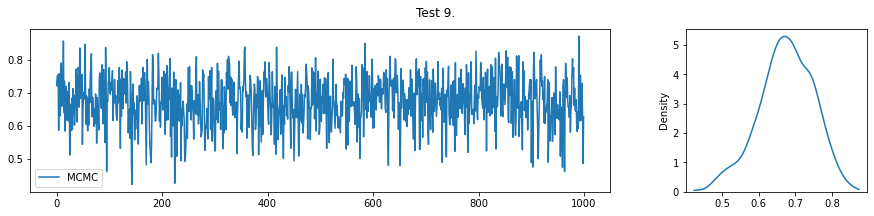

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [3.2, 1]})
ax1.plot(np.asarray(P[::50]), label='MCMC')
# x = [0, 50000]
# y = [0.6, 0.6]
# ax1.plot(x, y, label='Presice')
ax1.legend()
sns.kdeplot(np.asarray(P[200::50]), cut=0);
fig.suptitle('Test 9.')

In [59]:
np.all(np.abs(P)<1)

True

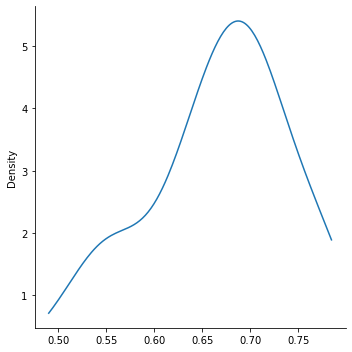

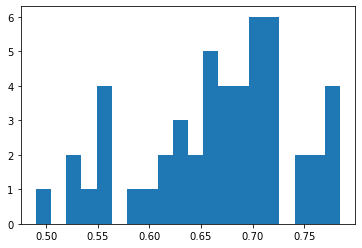

In [60]:
sns.displot(np.asarray(P[::1000]), kind='kde', cut=0);
plt.show()
plt.hist(P[::1000], bins=20);

In [61]:
num_reads, num_genomes = MC.shape

In [62]:
p = np.array([0.5] + [1/(num_genomes-1)]*(num_genomes-1))

In [63]:
%timeit get_Zi(MC, p, num_genomes, 2)

1.06 µs ± 11.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [64]:
dif

NameError: name 'dif' is not defined

In [ ]:
contamix_ref[514]

In [ ]:
cons[16179]

In [ ]:
def get_num_indels(bam_fname, trunc = 7):
    samfile = pysam.AlignmentFile(bam_fname, "rb" )
    num_reads = 0
    for read in samfile.fetch('chrM'):
        if not read.is_mapped or read.pos < trunc:
            continue
        if "I" in read.cigarstring:
            num_reads += 1
    samfile.close()
    return num_reads

In [ ]:
get_num_indels(bam)

In [ ]:
def get_cigar_string(bam_fname):
    ''''
    This function calculate mapped reads
    '''
    samfile = pysam.AlignmentFile(bam_fname, "rb" )
    
    for read in samfile.fetch('chrM'):
    print(read.cigartuples)
    samfile.close()

In [ ]:
samfile = pysam.AlignmentFile(bam, "rb" )
read = list(samfile.fetch('chrM'))[432]
print(read.cigartuples)
print(aln_coords[read.pos])
print(read.seq)
genome = (''.join( np.array(genomes_arr, dtype = str)[1])).upper()
print(genome[213: 326].replace('-',''))

In [ ]:
j = 0
for i in range(num_reads):
    if (MC[i,:].sum()) == 0:
        print(i)

In [ ]:
get_num_reads(bam)

In [ ]:
def calculate_likelihood(probs, mc):
    probs = np.asarray(probs)
    num_reads, num_genomes = mc.shape
    log_l = 0
    for i in range(num_reads):
        log_l += np.log((probs*MC[i,:]).sum())
    return log_l

            

In [ ]:
calculate_likelihood([0.8, 0.2, 0], MC)

In [ ]:
calculate_likelihood([0.7, 0.1, 0.2], MC)

In [ ]:
calculate_likelihood([0.99, 0.01, 0], MC)

In [ ]:
p3 = np.asarray([0.9] + [0.1]*(num_genomes-1))

In [ ]:
np.where(M[:,0]>M[:,1]+5)

In [ ]:
calculate_likelihood(p3, MC)

In [ ]:
p4 = np.asarray([0.7] + [0.3/(num_genomes-1)]*(num_genomes-1))

In [ ]:
calculate_likelihood([0.8, 0.2], MC)

In [ ]:
p5 = np.asarray([0.6] + [0.4/(num_genomes-1)]*(num_genomes-1))

In [ ]:
calculate_likelihood(p5, MC)

In [ ]:
seq1==seq2

In [ ]:
genomes_arr

In [ ]:
def get_probs(mc, p):
    num_reads, num_genomes = mc.shape
    p = np.asarray(p)
    
    probs = np.zeros_like(mc)
    # probs = np.zeros(num_genomes, dtype = float)
    for i in range(num_reads):
        s = 0
        for j in range(num_genomes):
            probs[i, j] = mc[i, j] * p[j]
            s += probs[i, j]
        for j in range(num_genomes):
            probs[i, j] = probs[i, j] / s
    return probs

In [ ]:
f = get_probs(MC,[0.5, 0.5])

In [ ]:
(f[:,0]>f[:,1]).mean()

In [ ]:
p = np.array([0.5, 0.5])

In [ ]:
np.where(np.bitwise_and((-1<M[:,0]),  M[:,0]+1<M[:,1]))[0].shape

In [ ]:
np.where(M[:,0]<M[:,1])[0].shape

In [ ]:
M[1590]
# N[1590]

In [ ]:
genome[801:801+100]

In [ ]:
read.pos

In [ ]:
genome1 = (''.join( np.array(genomes_arr, dtype = str)[0])).upper()
genome2 = (''.join( np.array(genomes_arr, dtype = str)[1])).upper()

In [ ]:
s = 100
print(genome1[s: s+100])
print(genome2[s: s+100])

In [ ]:
M[19245, 1]

In [ ]:
import sys

In [ ]:
np.set_printoptions(threshold=300)

In [ ]:
np.where(-1 < M[:,0])[0][0:]

In [ ]:
M[598]

In [ ]:
np.where(np.bitwise_and(M[:,1]<N[:,1], M[:,0] != -1))

In [ ]:
p

In [ ]:
get_probs(MC, p, 158)

In [ ]:
np.where(np.bitwise_and(M[:,1]>M[:,0]+1, M[:,0]>0))[0].shape

In [ ]:
np.where(M[:,0]<M[:,1])[0]

In [ ]:
M[101]

In [ ]:
(M[:,0]>M[:,1]).sum()

In [ ]:
N[157]

In [ ]:
M.shape

In [ ]:
genomes0.count('-')

In [ ]:
genome1 = (''.join( np.array(genomes_arr, dtype = str)[1])).upper()

In [ ]:
in10_1 =  genome.replace('-', '')

In [ ]:
f = open('data/bam/in10.fa')
in10 = f.read()[5:].replace('\n', '')
f = open('data/bam/in1.fa')
in1 = f.read()[5:].replace('\n', '')

In [ ]:
dif = [i for i in range(16569) if consensus[i] != in10[i]]

In [ ]:
dif

In [ ]:
cons = bam2consensus('data/bam/output40_in1_60_in10.bam', 1, 0.5)

In [ ]:
cons1 = pysam.consensus('data/bam/output40_in1_60_in10.bam')[5:].replace('\n','')

In [ ]:
len(cons)

In [ ]:
len(cons1)

In [ ]:
dif = [i for i in range(len(cons1)) if cons[i] !=cons1[i]]

In [ ]:
A = 300
B = 30
print(cons[A: A + B])
print(cons1[A: A + B])

In [ ]:
cons.count('N')

In [ ]:
def glMC()